In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import Constants as C
from PlotTool import PlotTool
from Loader import Loader
from Cuts import qlayerCut, firstHitInOuter, maxDistMaxDoms, balloonCut

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss


In [2]:
# Load the data and apply the baseline selection.  Keep only
# the features we are going to use

b_features = C.bdt_features

# Weigth branches for book keeping
weights = ['w','wE2',
           'PrimaryNeutrinoEnergy','OneWeight',
           'NEvents','evtid','runid',
          ]

# Define the baseline selection
basesel = C.basesel 
basesel += "&&(ImpLF_rchi2 > 80)" # To be orthogonal to EHEAlert selection
#L3 = "&&(rho_travel < 250 && hs_z_travel > -200 && hs_z_travel < 100 && tlarge5[0]-tearly5[0] < 200)"
#L3 = "&&(hs_z_travel > -200 && hs_z_travel < 100 && tlarge5[0]-tearly5[0] < 200)"
L3 = '&&(tlarge5[0]-tearly5[0] < 200)'
basesel += L3

# Get data
loader = Loader(basesel)
d_nue  = loader.getNuE() 
d_data = loader.getData()

# Want to keep astro weights as well. Insert dummy astro
d_data['w'] = pd.Series(np.ones(len(d_data['rho_travel']),dtype=float),index=d_data.index)
d_data['wE2'] = d_data['w']
d_data['PrimaryNeutrinoEnergy'] = pd.Series(np.zeros(len(d_data['w']),dtype=float), index=d_data.index)

# Insert the targets
d_nue['target'] = pd.Series(np.ones(len(d_nue['w']),dtype=int), index=d_nue.index)
d_data['target'] = pd.Series(np.zeros(len(d_data['w']),dtype=int), index=d_data.index)

# Select outer events only
d_nue = qlayerCut(d_nue,False,0.8)
d_data = qlayerCut(d_data,False,0.8)

# Remove balloon events
d_nue = balloonCut(d_nue)
d_data = balloonCut(d_data)

# Remove -200 to 0
def cogzcut(dt):
    return dt[((-200 > dt.hs_cogz) | (dt.hs_cogz > 0))]
#d_nue = cogzcut(d_nue)
#d_data = cogzcut(d_data)

# Only keep events that have hit in outer list
#d_nue = firstHitInOuter(d_nue)
#d_data = firstHitInOuter(d_data)

# Insert the maxdist var
d_nue['maxDist'] = maxDistMaxDoms(d_nue)
d_data['maxDist'] = maxDistMaxDoms(d_data)
#d_nue = d_nue[ d_nue['maxDist'] < 300 ]
#d_data = d_data[ d_data['maxDist'] < 300 ]

# Separate high energy and low energy
d_he_nue = d_nue[np.log10(d_nue['PrimaryNeutrinoEnergy']) >= 6] 
d_le_nue = d_nue[np.log10(d_nue['PrimaryNeutrinoEnergy']) < 6]

# Select off only the features we want for training
d_he_nue = d_he_nue[ b_features + weights +['target'] ]
d_le_nue = d_le_nue[ b_features + weights +['target'] ]
d_data   = d_data[ b_features + weights + ['target'] ]


In [3]:
# Break into testing and training data sets
trainfrac = 0.5
X_nue_train, X_nue_test, y_nue_train, y_nue_test = train_test_split(d_he_nue[b_features+weights],
                                                                    d_he_nue['target'],
                                                                    train_size=trainfrac,
                                                                    random_state=194637)

X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(d_data[b_features+weights],
                                                                    d_data['target'],
                                                                    train_size=trainfrac,
                                                                    random_state=194637)

# Normalize the training set weights
X_nue_train.loc[:,'wE2'] *= 1. / sum(X_nue_train['wE2'])
X_dt_train.loc[:,'wE2']  *= 1. / sum(X_dt_train['wE2'])

# Now mix sig and bkg
X_train = X_nue_train.append(X_dt_train)
X_test  = X_nue_test.append(X_dt_test)
y_train = y_nue_train.append(y_dt_train)
y_test  = y_nue_test.append(y_dt_test)

# Adjust the weights
#X_train['w'] *= 1/trainfrac
X_test.loc[:,'w']  *= 1/(1-trainfrac)

#X_train['wE2'] *= 1/trainfrac
X_test.loc[:,'wE2']  *= 1/(1-trainfrac)

print "-------------------------"
print "Consistency check:"
print "Data: ", sum(X_train[ y_train < 0.5 ]['wE2']), sum(X_test[ y_test < 0.5 ]['wE2']) 
print "E^-2:    ", sum(X_train[ y_train > 0.5 ]['wE2']), sum(X_test[ y_test > 0.5 ]['wE2'])


-------------------------
Consistency check:
Data:  1.0 35700.0
E^-2:     1.0 0.379150277234


In [4]:
# Ok now we have our data separated and we can train our classifier
# In a separate script, do a grid search to best determine the hyper parameters.
# Here we can train the classifier

rs1 = 0 #9182734
rs2 = 47382 #918273 #564293

def classifier(ntrees,maxdepth,minsplit,learningrate,sl,maxfeat,alg):

    # Using a BDT for now
    decisiontree = DecisionTreeClassifier(max_depth=maxdepth,
                                          min_samples_split=minsplit,
                                          max_features=maxfeat,
                                          min_samples_leaf=sl,
                                          random_state=rs1)
    clf = AdaBoostClassifier(decisiontree,
                             n_estimators=ntrees,
                             learning_rate=learningrate,
                             algorithm=alg,
                             random_state = rs2
                            )

    return clf

def train(clf, X, y):
    global b_features
    clf.fit(X[ b_features ], y, sample_weight=X['wE2'].as_matrix())
    return clf

In [5]:
import matplotlib.pyplot as plt
pt = PlotTool()

# define the signal and background for later
#dt_sig = X_test[ y_test > 0.5 ]
#dt_bkg = X_test[ y_test < 0.5 ]

In [6]:
# Make a method to plot data and bkg
def plotbdt(clf, X_test, y_test, cutval=-1,title=""):

    # Get the scores
    X_test['scores'] = pd.Series(clf.decision_function(X_test[b_features]),
                            index = X_test.index)

    # Divide up sig and bkg
    dt_sig = X_test[ y_test > 0.5 ]
    dt_bkg = X_test[ y_test < 0.5 ]

    # Now plot them
    sf = 365/34.7
    fig,ax = plt.subplots(ncols=1,figsize=(7,6))
    pt.ploth1(dt_sig['scores'].as_matrix(),
              dt_sig['wE2'].as_matrix(), # * sf,
              'BDT Score','Events / year / bin',
              r'Astro. $\nu_{e}$ (E>1PeV)',
              50,-1,1,'b',
              False,False)
    pt.ploth1(dt_bkg['scores'].as_matrix(),
              dt_bkg['w'].as_matrix(), # * sf,
              'BDT Score','Events / year / bin',
              r'Data (50%)',
              50,-1,1,'r',
              False,False)

    plt.title(title)
    plt.grid()
    plt.legend(loc='best')
    if cutval > 0:
        plt.plot([cutval,cutval],[1e-6,1e7],lw=2,ls='dashed',c='black')

    ax.set_yscale('log')

    # Let's also print out the expected sig 
    # and background for some cutvalues
    cuts = np.arange(0.4,0.8,0.05)
    for cut in cuts:
        print "Cut:", cut
        print "\tData: %f"%(sum(dt_bkg[ dt_bkg['scores'] > cut]['w'])*sf)
        print "\tAstro:   %f"%(sum(dt_sig[ dt_sig['scores'] > cut]['wE2'])*sf)


Cut: 0.4
	Data: 63.112392
	Astro:   3.035582
Cut: 0.45
	Data: 0.000000
	Astro:   2.862222
Cut: 0.5
	Data: 0.000000
	Astro:   2.687523
Cut: 0.55
	Data: 0.000000
	Astro:   2.508542
Cut: 0.6
	Data: 0.000000
	Astro:   2.307549
Cut: 0.65
	Data: 0.000000
	Astro:   2.035152
Cut: 0.7
	Data: 0.000000
	Astro:   1.664418
Cut: 0.75
	Data: 0.000000
	Astro:   1.257989


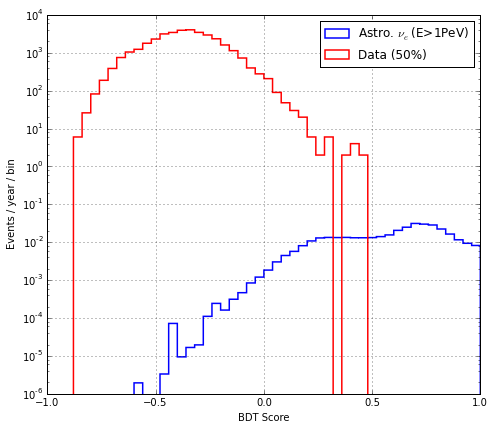

In [119]:
# Second Best
clf = classifier(300,4,5000,0.1,200,3,'SAMME.R')
clf = train(clf, X_train, y_train)
plotbdt(clf, X_test, y_test)

Cut: 0.4
	Data: 63.112392
	Astro:   3.035582
Cut: 0.45
	Data: 0.000000
	Astro:   2.862222
Cut: 0.5
	Data: 0.000000
	Astro:   2.687523
Cut: 0.55
	Data: 0.000000
	Astro:   2.508542
Cut: 0.6
	Data: 0.000000
	Astro:   2.307549
Cut: 0.65
	Data: 0.000000
	Astro:   2.035152
Cut: 0.7
	Data: 0.000000
	Astro:   1.664418
Cut: 0.75
	Data: 0.000000
	Astro:   1.257989


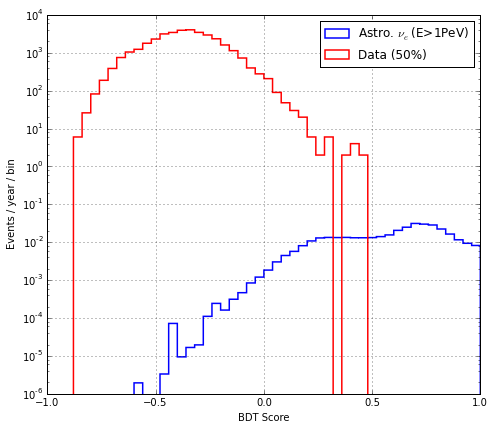

In [7]:
# Second Best
clf = classifier(300,4,5000,0.1,200,3,'SAMME.R')
clf = train(clf, X_train, y_train)
plotbdt(clf, X_test, y_test)

In [11]:
fi = clf.feature_importances_
tot = 0
for i in range(len(b_features)):
    print b_features[i], "%.2f"%fi[i]
    tot += fi[i]
print "Total:", tot

hs_z_travel 0.20
rho_travel5 0.07
ImpLF_rchi2 0.13
ndoms_5pe 0.10
nstr_2ndway_5pe 0.06
log10(hs_q_tot_pulses) 0.07
maxDist 0.05
cumuAt600ns 0.10
hs_cogz 0.16
sqrt(hs_cogx*hs_cogx+hs_cogy*hs_cogy) 0.06
Total: 1.0


In [12]:
# Write the model out
from sklearn.externals import joblib

joblib.dump(clf, '../models/bdt_hyperparamopt_cleaningupdate.pkl')
print "" # don't print out all that joblib stuff...

In [14]:
# Those weird guys sticking out are from what??
dt_bkg = X_test[ y_test < 0.5 ]
peal = dt_bkg[ dt_bkg['scores'] > 0.35]

#runs = peal.runid.as_matrix()
#evts = peal.evtid.as_matrix()
#outfile = open('bs_hyperopt_cut05.txt','w')
#for i in range(len(runs)):
#    outfile.write(str(runs[i])+" "+str(evts[i])+"\n")
#outfile.close()

peal[['evtid','runid','scores','log10(hs_q_tot_pulses)','ndoms_5pe','nstr_2ndway_5pe','hs_cogz','hs_z_travel','rho_travel5','ImpLF_rchi2','cumuAt600ns']]

,evtid,runid,scores,log10(hs_q_tot_pulses),ndoms_5pe,nstr_2ndway_5pe,hs_cogz,hs_z_travel,rho_travel5,ImpLF_rchi2,cumuAt600ns
39060,65295085,121390,0.440529,3.595195,78,12,-447.630624,31.160356,151.909783,203.114456,0.769728
43194,10288350,121450,0.438434,4.280505,135,12,-304.816041,-54.353349,147.965334,86.421513,0.850244
29100,38079124,120810,0.364551,4.093654,61,8,482.076243,-73.679767,136.844039,123.141500,0.827030
31558,64449045,120860,0.413385,4.271562,158,13,-311.898495,-65.257499,130.118338,138.418693,0.800454


In [48]:
dt_sig = X_test[ y_test > 0.5 ]
print sum(dt_sig.wE2) * 365/34.7
print sum(dt_sig[ dt_sig.scores > 0.5].wE2) * 365 / 34.7
print sum(dt_sig[ (dt_sig.scores > 0.5) & (np.fabs(dt_sig.hs_cogz) < 450)].wE2) * 365 / 34.7

3.98818014958
2.96206752812
2.28660525893


In [24]:
dt_sig = X_test[ y_test > 0.5 ]
print sum(dt_sig.wE2) * 365/34.7
print sum(dt_sig[ np.fabs(dt_sig.hs_cogz) <= 450 ].wE2) * 365/34.7

3.82570837033
3.04380307444


In [8]:
# Re-establish sig and bkg from bdt
dt_sig = X_test[ y_test > 0.5 ]
dt_bkg = X_test[ y_test < 0.5 ]

In [9]:
# Let's also bring in the  remaining simulation and evaluate the bdt

# Grab missing files
d_numu = loader.getNuMu()
d_cor  = loader.getCorsika()

# apply some selection
d_numu = qlayerCut(d_numu, False, 0.8)
d_cor = qlayerCut(d_cor, False, 0.8)


# Apply balloon cut
d_numu = balloonCut(d_numu)
d_cor  = balloonCut(d_cor)

#d_cor = cutcogz(d_cor)

# Add the maxDist parameter
d_numu['maxDist'] = maxDistMaxDoms(d_numu)
d_cor['maxDist'] = maxDistMaxDoms(d_cor)

# Drop unnecessary stuff
#d_numu = d_numu[ b_features + weights ]
#d_cor = d_cor[ b_features + ['w'] ]


In [10]:
# Evaluate for Corsika
d_cor = d_cor.dropna()
d_cor['scores'] = pd.Series(clf.decision_function( d_cor[b_features] ), index=d_cor.index)

# Evaluate for numu
d_numu = d_numu.dropna()
d_numu['scores'] = pd.Series(clf.decision_function( d_numu[b_features] ), index=d_numu.index)

# Get LE nue that hasn't been used
d_le_nue = d_le_nue.dropna()
d_le_nue['scores'] = pd.Series(clf.decision_function( d_le_nue[b_features] ), index=d_le_nue.index)

# Put nue back together
dt_nue = pd.concat([d_le_nue, dt_sig])

# Combine sim
dt_sig_copy = dt_sig.copy()
dt_sig_copy['w'] = dt_sig_copy['wE2']
d_numu_copy = d_numu.copy()
d_numu_copy['w'] = d_numu_copy['wE2']

#dt_mc = pd.concat([d_cor, d_nue, dt_sig, d_numu, dt_sig_copy, d_numu_copy])
#dt_mc = pd.concat([d_cor, d_nue])


In [11]:
dt_mc = pd.concat([d_cor, dt_nue, d_numu])

In [12]:
# Build the info
info = {'data'     : [dt_bkg, 
                      dt_mc, 
                      d_cor, 
                      dt_nue,
                      d_numu,
                      dt_nue,
                      d_numu
                     ],
        'names'    : ['Data (50%)',
                      'Total Bkg.', 
                      r'Atmos. $\mu$',
                      r'Atmos. $\nu_{e}$', 
                      r'Atmos. $\nu_{\mu}$',
                      r'Astro. $\nu_{e}$',
                      r'Astro. $\nu_{\mu}$'],
        'weights' : ['w','w','w','w','w','wE2','wE2'], 
        'colors'  : ['black', 'r', 'm', 'g', 'b', 'y', 'c'],
        'lw'      : [0, 1.5, 1.5, 1.5, 1.5,1.5,1.5],
        'ls'      : ['solid','dashed','solid','solid','solid','solid','solid'],
        'marker'  : ['.',' ', ' ', ' ', ' ',' ',' ']
        }


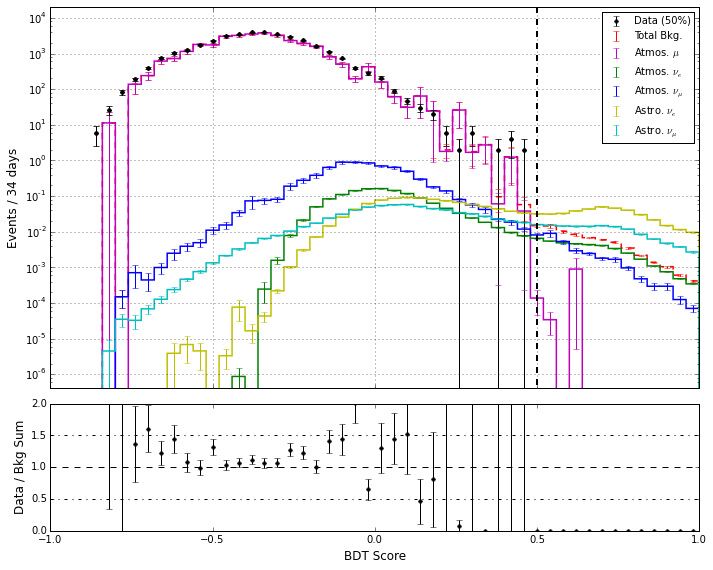

In [13]:
# Plot the scores
pt.plotStackedRatio(info,'scores','BDT Score', 
                    50, -1, 1, 
                    1e-10, True, False, False,
                    #"","Data / Sig+Bkg"
                   )
plt.plot([0.5,0.5],[1e-10,1e10],lw=2,ls='dashed',c='black')
#plt.savefig('../plots/mvaana/bdts/datamc_bdtscore_300trees_1000Split_depth4_maxfeatSQRT_minsampleaf200_lr01_datatrained_srtupdate.png')
#plt.savefig('../plots/mvaana/bdts/datamc_bdtscore_JPSMarch2016.png')

In [14]:
# Print the rates
for i in range(len(info['data'])):
    dt = info['data'][i]
    name = info['names'][i]
    w = info['weights'][i]
    print name, sum(dt[ dt.scores > 0.5 ][w]) * 365/34.7

Data (50%) 0.0
Total Bkg. 0.715417118111
Atmos. $\mu$ 0.0108412900826
Atmos. $\nu_{e}$ 0.393208236739
Atmos. $\nu_{\mu}$ 0.311367591289
Astro. $\nu_{e}$ 4.25103289969
Astro. $\nu_{\mu}$ 1.44978958206


In [15]:
# Methods to plot effective area
from math import pi,log10

xmin  = 3
xmax  = 7
nbins = 20.
#bins = np.arange(3,9.1,0.3)
ebins_per_decade = float(nbins/(xmax-xmin))
solidangle = 4*pi

def mcLogEBin(E):
    return int(log10(E)*ebins_per_decade)
def mcEMin(mc_log_ebin):
    return pow(10,mc_log_ebin/ebins_per_decade)
def mcEMax(mc_log_ebin):
    return pow(10,(1+mc_log_ebin)/ebins_per_decade)

# Calculate effective area
def getEffA(data, isbdt, nfiles):
    effA = np.zeros(len(data['PrimaryNeutrinoEnergy']),dtype=float)
    energy = np.empty(len(data['PrimaryNeutrinoEnergy']),dtype=float)        
    fnorm  = 1. / nfiles
    
    dt_E = data['PrimaryNeutrinoEnergy'].as_matrix()
    dt_oneweight = data['OneWeight'].as_matrix()
    dt_nevents   = data['NEvents'].as_matrix()
    for i in range(len(effA)):

        E = dt_E[i]
        OneWeight = dt_oneweight[i]
        NEvents   = dt_nevents[i]
        mclogebin = mcLogEBin(E)
        mcemin = mcEMin(mclogebin)
        mcemax = mcEMax(mclogebin)
        
        sf = 1
        if isbdt and np.log10(E) >=6:
            sf = 1/0.5 # This shouldn't be hard-coded!!!
        
        
        effA[i] = 1e-4 * OneWeight * fnorm/NEvents * 1/(solidangle*(mcemax-mcemin)) * sf
        energy[i] = log10(E)

    return effA, energy

def plotEffA(nrg, effa, col, lbl,ls='solid'):
        plt.hist(nrg,
                 weights=effa,
                 color=col,
                 label=lbl,
                 range=(xmin,xmax),
                 bins = nbins,
                 histtype='step',
                 lw = 1.5,
                ls = ls)


4.25103289969


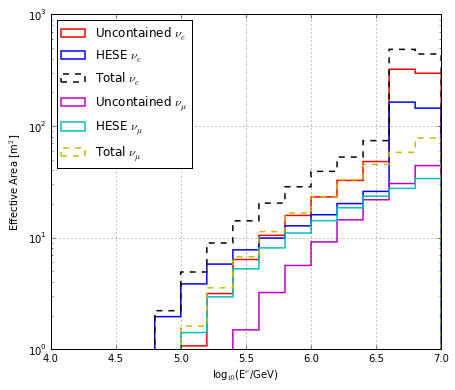

In [16]:
# Now plot the effective area for nu_e events from HESE
# and those passing the new BDT selection

# Load the hese data set
heseloader = Loader('(passHESE)')
dt_hese = heseloader.getNuE()
dt_hese_numu = heseloader.getNuMu()

# Select off the nue events that pass the bdt cut
bdtcut = 0.5
nue_pass = dt_nue[ dt_nue['scores'] > bdtcut]
numu_pass = d_numu[ d_numu['scores'] > bdtcut ]
print sum(nue_pass['wE2']) *365/34.7

# Now evaluate effective area
new_effa, new_e = getEffA(nue_pass, True, C.nugen_nue_12034_nfiles)
hese_effa, hese_e = getEffA(dt_hese, False, C.nugen_nue_12034_nfiles)
hesenumu_effa, hesenumu_e = getEffA(dt_hese_numu, False, C.nugen_henumu_nfiles)
numu_effa, numu_e = getEffA(numu_pass, False, C.nugen_henumu_nfiles)

# Now plot
fig,ax = plt.subplots(figsize=(7,6))
plotEffA(new_e, new_effa, 'r', r'Uncontained $\nu_{e}$')
plotEffA(hese_e, hese_effa, 'b', r'HESE $\nu_{e}$')
plotEffA(np.concatenate([new_e, hese_e]),
         np.concatenate([new_effa, hese_effa]),
         'black', r'Total $\nu_{e}$','dashed')

plotEffA(numu_e, numu_effa, 'm', r'Uncontained $\nu_{\mu}$')
plotEffA(hesenumu_e, hesenumu_effa, 'c', r'HESE $\nu_{\mu}$')
plotEffA(np.concatenate([numu_e, hesenumu_e]),
         np.concatenate([numu_effa, hesenumu_effa]),
         'y', r'Total $\nu_{\mu}$','dashed')


ax.set_ylim([1e0,1e3])
ax.set_xlim([4,7])
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(E$^{\nu}$/GeV)')
plt.ylabel(r'Effective Area [m$^{2}$]')
plt.grid()
plt.legend(loc='upper left')
#plt.savefig('../plots/mvaana/EffectiveArea/effa_cut08_500trees_50kSplit_depth3_datatrained.png')
#plt.savefig('../plots/mvaana/EffectiveArea/effa_cut06_500trees_30kSplit_depth2_datatrained.png')
#plt.savefig('../plots/temp_jps/EffectiveArea_Unct_HESE.png')

In [17]:
# Save the effective area output in a pkl file to analyze later
def histthat(energy, effa):
    global nbins, xmin, xmax
    heffa, ebins = np.histogram(energy, 
                                weights=effa,
                                bins=nbins,
                                range=(xmin,xmax))
    ecenter = (ebins[:-1]+ebins[1:])/2.
    return heffa, ebins, ecenter

# Get summary results for 4 cases
e_unct = histthat(new_e, new_effa)
e_hese = histthat(hese_e, hese_effa)
mu_unct = histthat(numu_e, numu_effa)
mu_hese = histthat(hesenumu_e, hesenumu_effa)

stuff = {'e_effa_unct' : e_unct[0], 'e_bins_unct' : e_unct[1], 'e_cent_unct' : e_unct[2],
         'e_effa_hese' : e_hese[0], 'e_bins_hese' : e_hese[1], 'e_cent_hese' : e_hese[2],
         'mu_effa_unct' : mu_unct[0], 'mu_bins_unct' : mu_unct[1], 'mu_cent_unct' : mu_unct[2],
         'mu_effa_hese' : mu_hese[0], 'mu_bins_hese' : mu_hese[1], 'mu_cent_hese' : mu_hese[2]
         }

import pickle
pickle.dump(stuff, open('Uncontained_HESE_effa_Mar23.pkl','w'))